# CNN+LSTM 전력 수요 예측 

### <목차>

### <화면 가로 확장>

In [1]:
# 화면 가로 확장 코드 (기본 width 50%)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### 1. 모듈 임포트

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import tensorflow as tf
import csv
import os
import datetime
import time
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split
from scipy.stats import norm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, LSTM, Bidirectional, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.wrappers import TimeDistributed
import keras

from keras.utils.vis_utils import plot_model
import pydot
import pydotplus
import graphviz

from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [3]:
try:
    os.mkdir('./Result')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


### <GPU 확인>

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

### 데이터 로드

In [10]:
Data_13=pd.read_csv('./Combined_Data_New/2013_House1_Ch1_Combined_Data_New_Y.csv', encoding='cp949')
Data_14=pd.read_csv('./Combined_Data_New/2014_House1_Ch1_Combined_Data_New_Y.csv', encoding='cp949')
Data_15=pd.read_csv('./Combined_Data_New/2015_House1_Ch1_Combined_Data_New_Y.csv', encoding='cp949')
Data_16=pd.read_csv('./Combined_Data_New/2016_House1_Ch1_Combined_Data_New_Y.csv', encoding='cp949')

In [30]:
Data_4Y = pd.read_csv('./Combined_Data_New/House1_Ch1_Combined_Data_New_13-16.csv', encoding='cp949')
Data_4Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102400 entries, 0 to 2102399
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   Year-Month-Date  object 
 2   Time             object 
 3   Holiday          int64  
 4   Watt             int64  
 5   Temp('C)         float64
 6   Humidity(%)      float64
 7   CPI              float64
dtypes: float64(3), int64(3), object(2)
memory usage: 128.3+ MB


In [ ]:
Data_4Y

In [4]:
list_24=[]
for h in range(24):
    list_24.append(5760+60*h)

In [5]:
def SimpleGraph(title, plot, ylabel, savename):
    plt.figure(figsize=(150,20))
    plt.grid()
    plt.title(title, fontsize=180)
    plt.plot(plot)

    plt.xlabel("Time by Hour", fontsize=130)
    plt.ylabel(ylabel, fontsize=130)
    plt.margins(x=0.002)

    plt.xticks(list_24, labels=np.arange(24))

    plt.tick_params(axis='x', size=15)
    plt.tick_params(axis='x', labelsize=70)
    plt.tick_params(axis='y', size=15)
    plt.tick_params(axis='y', labelsize=70)
    plt.savefig("./Result/"+savename+".png", bbox_inches='tight',pad_inches=1)
    plt.show()

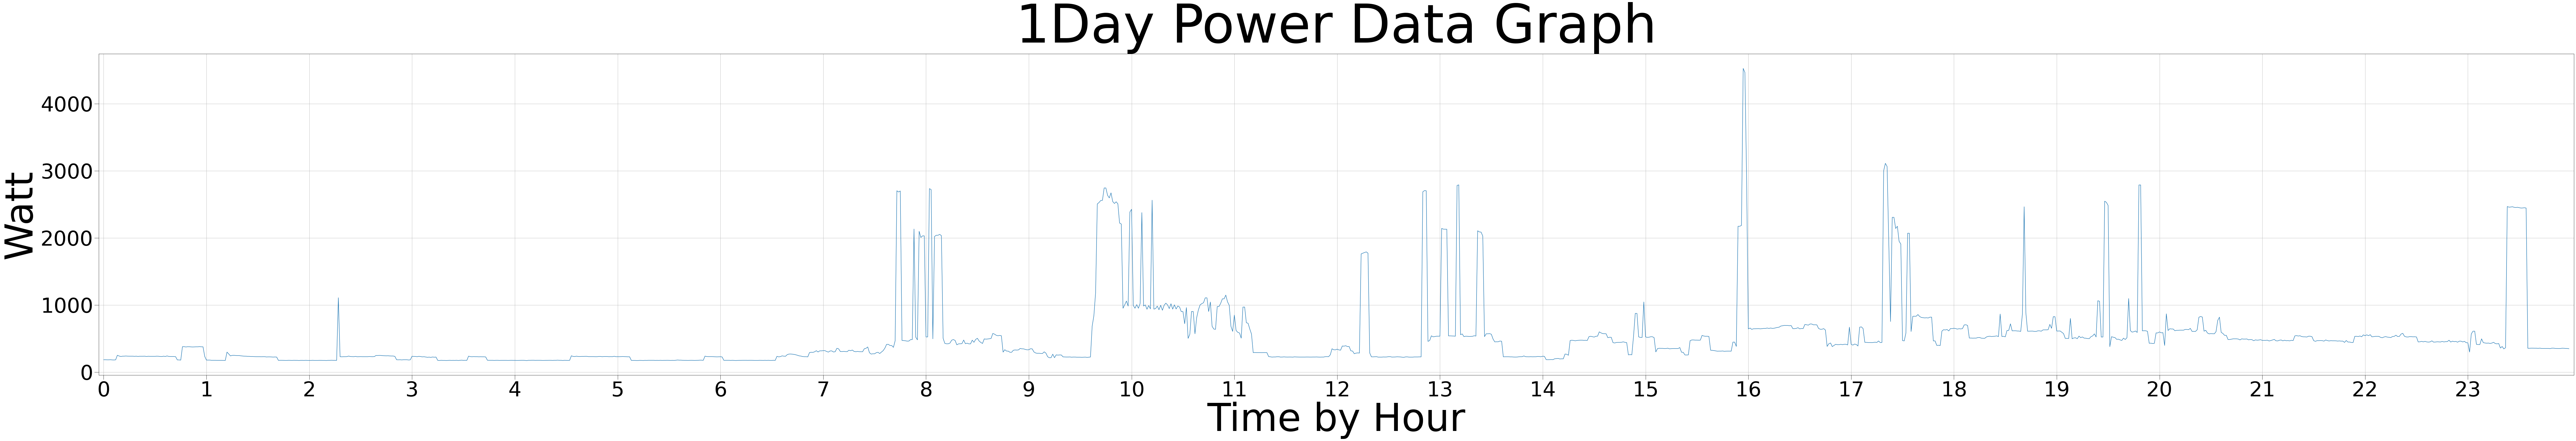

In [41]:
SimpleGraph("1Day Power Data Graph", Data_4Y["Watt"][5760:7200], "Watt", "1Day_Data_Watt")

### 이상치 처리

#### 전체 데이터(4년)의 이상치 판별 기준 추출

In [ ]:
def get_outlier(df=None, column=None, weight=None):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_50 = np.percentile(df[column].values, 50)
    quantile_75 = np.percentile(df[column].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight

    lowest_val = quantile_25-IQR_weight
    highest_val = quantile_75+IQR_weight
    
    outlier_index_low = df[column][df[column] < lowest_val].index
    outlier_index_high = df[column][df[column] > highest_val].index
    print(IQR_weight)
    return outlier_index_low, outlier_index_high, quantile_25, quantile_50, quantile_75, lowest_val, highest_val

In [ ]:
def get_list_outlier(df=None, column=None, low=None, high=None):
    outlier_index_low = df[column][df[column] < low].index
    outlier_index_high = df[column][df[column] > high].index
    
    return outlier_index_low, outlier_index_high

In [ ]:
one=(max(Data_4Y["Watt"])-min(Data_4Y["Watt"]))/100
Low_one=one*25
High_one=one*75
print(Low_one, High_one, (High_one-Low_one)*1.5)

In [ ]:
High_list_13=get_list_outlier(df=Data_13, column="Watt", low=Low_one, high=High_one)[1]
High_list_14=get_list_outlier(df=Data_14, column="Watt", low=Low_one, high=High_one)[1]
High_list_15=get_list_outlier(df=Data_15, column="Watt", low=Low_one, high=High_one)[1]
print("High List >>", len(High_list_13), len(High_list_14), len(High_list_15))

In [ ]:
for i in High_list_13:
    Data_13["Watt"][i:i+1] = High_one
for i in High_list_14:
    Data_14["Watt"][i:i+1] = High_one
for i in High_list_15:
    Data_15["Watt"][i:i+1] = High_one

In [ ]:
High_list_13=get_list_outlier(df=Data_13, column="Watt", low=Low_one, high=High_one)[1]
High_list_14=get_list_outlier(df=Data_14, column="Watt", low=Low_one, high=High_one)[1]
High_list_15=get_list_outlier(df=Data_15, column="Watt", low=Low_one, high=High_one)[1]
print(len(High_list_13), len(High_list_14), len(High_list_15))

In [ ]:
df_4Y = pd.DataFrame()
df_4Y = pd.concat([df_4Y, Data_13])
df_4Y = pd.concat([df_4Y, Data_14])
df_4Y = pd.concat([df_4Y, Data_15])
df_4Y = pd.concat([df_4Y, Data_16])
    
df_4Y = df_4Y.drop([df_4Y.columns[0]], axis=1)
df_4Y = df_4Y.reset_index(drop=True)
df_4Y.to_csv("./Combined_Data_New/House1_Ch1_Combined_Data_New_13-16_Outlier_Edited.csv", encoding='cp949')
print("Done!")

### Data Import

In [6]:
Data_4Y_Edited = pd.read_csv('./Combined_Data_New/House1_Ch1_Combined_Data_New_13-16_Outlier_Edited.csv', encoding='cp949')
Data_4Y_Edited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102400 entries, 0 to 2102399
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   Year-Month-Date  object 
 2   Time             object 
 3   Holiday          int64  
 4   Watt             float64
 5   Temp('C)         float64
 6   Humidity(%)      float64
 7   CPI              float64
dtypes: float64(4), int64(2), object(2)
memory usage: 128.3+ MB


#### to csv

In [12]:
Data_4Y_Edited_1 = Data_4Y_Edited.drop([Data_4Y_Edited.columns[0]], axis=1)

In [15]:
Data_4Y_Edited_1[:1440].to_csv("./Combined_Data_New/Sample_1Day_130101.csv", encoding='cp949')

#### Graph

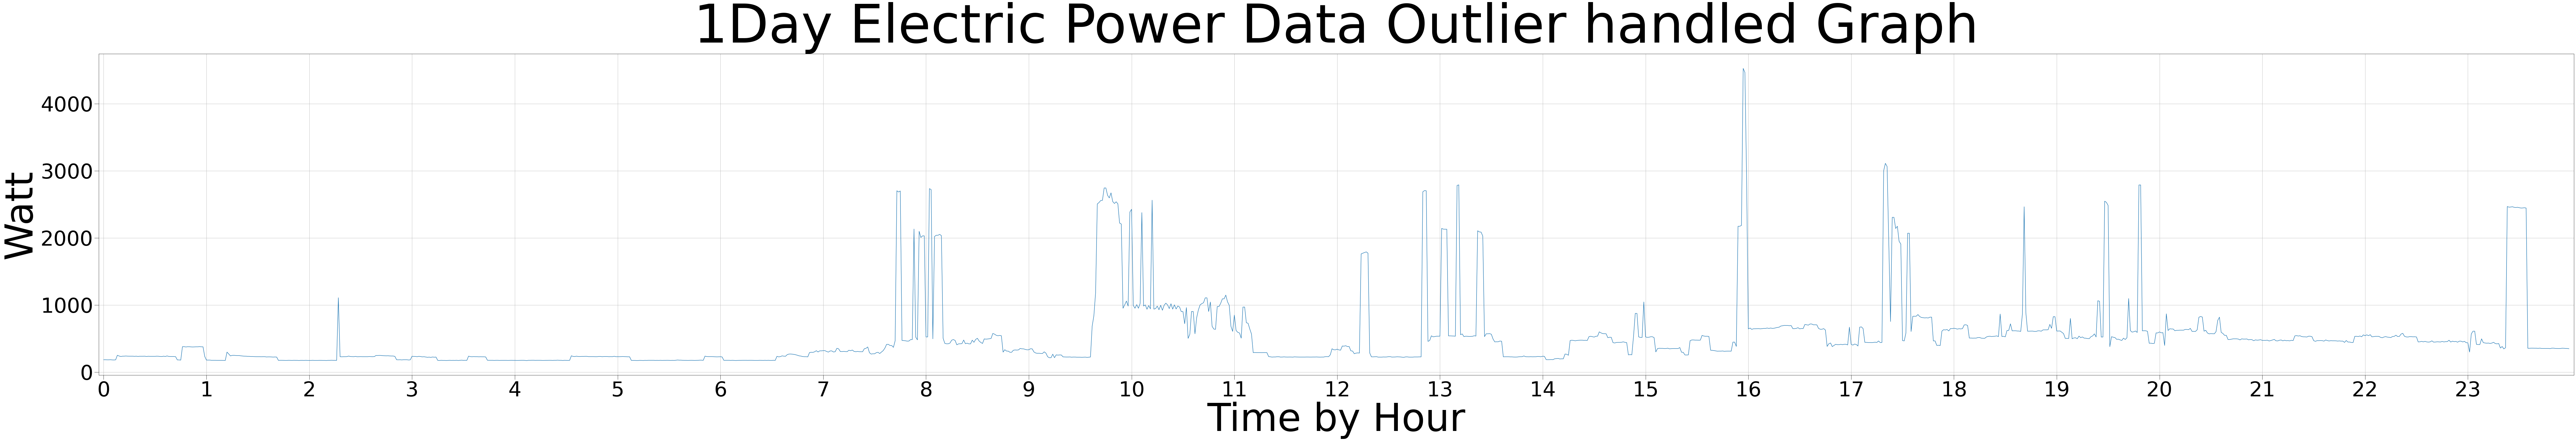

In [42]:
SimpleGraph("1Day Electric Power Data Outlier handled Graph", Data_4Y_Edited["Watt"][5760:7200], "Watt", "1Day_Outlier_Edited_Data_Watt")

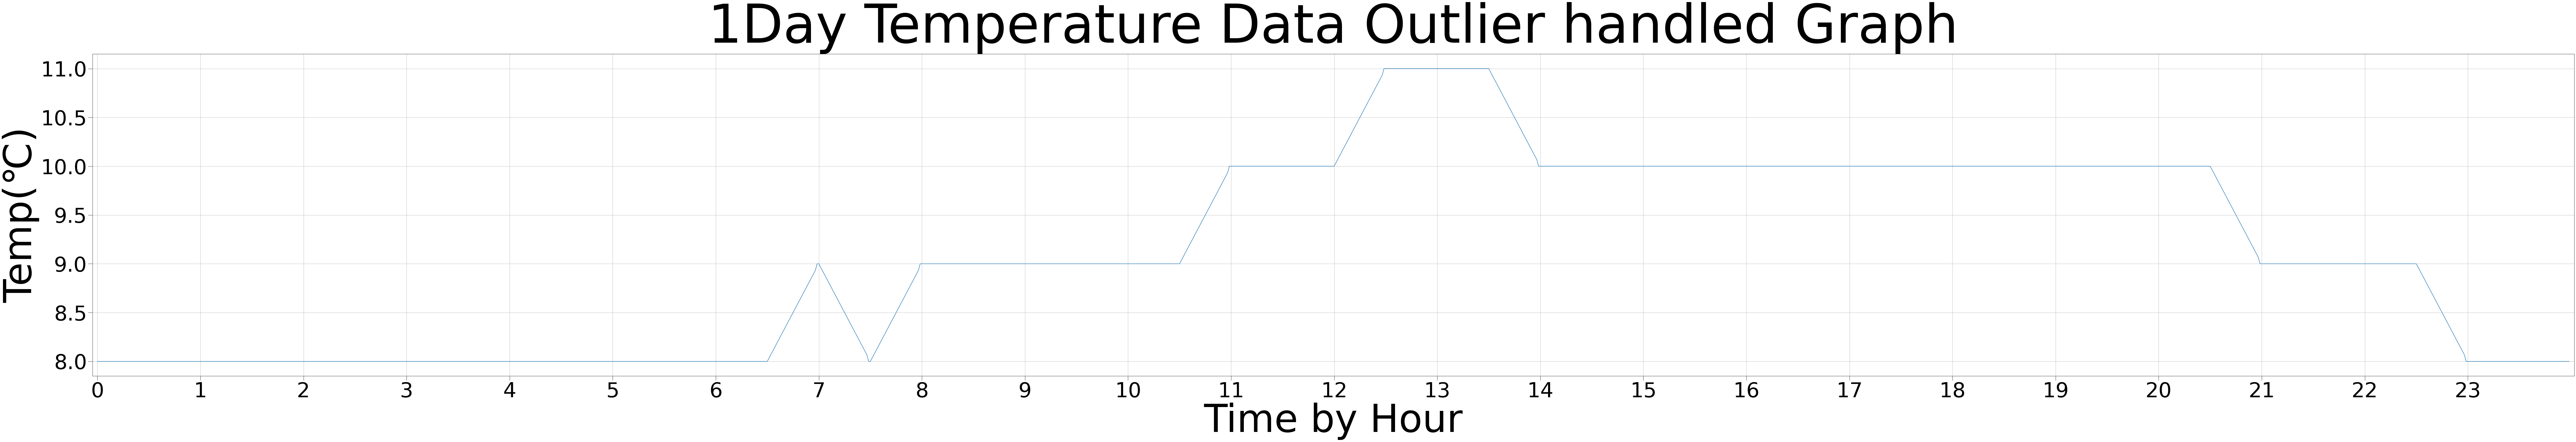

In [43]:
SimpleGraph("1Day Temperature Data Outlier handled Graph", Data_4Y_Edited["Temp('C)"][5760:7200], "Temp(℃)", "1Day_Outlier_Edited_Data_Temp")

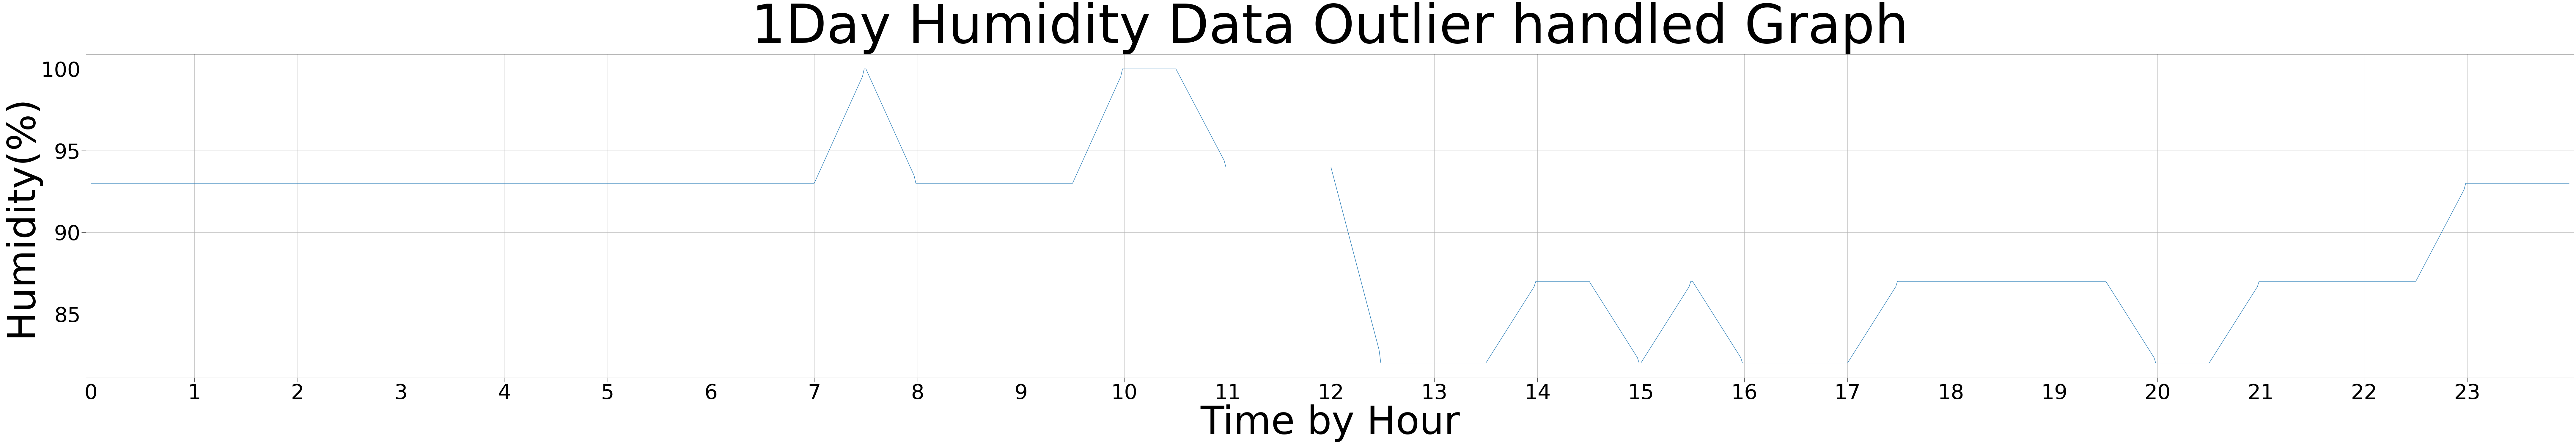

In [44]:
SimpleGraph("1Day Humidity Data Outlier handled Graph", Data_4Y_Edited["Humidity(%)"][5760:7200], "Humidity(%)", "1Day_Outlier_Edited_Data_Humidity")

### 4. 데이터 정규화

#### Min-Max Scaling 이용, 4년치 학습 데이터 정규화

In [22]:
"""
<StandardScaler>
from sklearn.preprocessing import StandardScaler
평균 0, 분산1 로 조정
가우시안 분포된 선형 데이터나 SVM에 사용

<RobustScaler>
from sklearn.preprocessing import RobustScaler
평균과 분산 대신 중간값과 사분위 값을 사용.
이상치에 Robustic한 반응을 보임.

<MinMaxScaler>
모든 값을 0~1 사이로 정규화
원데이터 분포를 유지하면서 정규화하는 방법
가우시안 분포를 띄지 않는 데이터에 사용

<Normalizer>
from sklearn.preprocessing import Normalizer
특성 벡터의 모든 길이가 1이 되도록 조정, 
특성 벡터의 길이보다는 데이터의 방향이나 각도가 중요할 경우 사용

<QuantileTransformer>
from sklearn.preprocessing import QuantileTransformer
1000개의 분위를 사용하여 데이터를 균등분포 시킴.
Robustic한 특성을 지니며, 데이터들은 0~1 사이로 압축됨.

<PowerTransformer>
from sklearn.preprocessing import PowerTransformer
데이터의 특성별로 정규분포 형태에 가깝도록 변환
"""

'\n<StandardScaler>\nfrom sklearn.preprocessing import StandardScaler\n평균 0, 분산1 로 조정\n가우시안 분포된 선형 데이터나 SVM에 사용\n\n<RobustScaler>\nfrom sklearn.preprocessing import RobustScaler\n평균과 분산 대신 중간값과 사분위 값을 사용.\n이상치에 Robustic한 반응을 보임.\n\n<MinMaxScaler>\n모든 값을 0~1 사이로 정규화\n원데이터 분포를 유지하면서 정규화하는 방법\n가우시안 분포를 띄지 않는 데이터에 사용\n\n<Normalizer>\nfrom sklearn.preprocessing import Normalizer\n특성 벡터의 모든 길이가 1이 되도록 조정, \n특성 벡터의 길이보다는 데이터의 방향이나 각도가 중요할 경우 사용\n\n<QuantileTransformer>\nfrom sklearn.preprocessing import QuantileTransformer\n1000개의 분위를 사용하여 데이터를 균등분포 시킴.\nRobustic한 특성을 지니며, 데이터들은 0~1 사이로 압축됨.\n\n<PowerTransformer>\nfrom sklearn.preprocessing import PowerTransformer\n데이터의 특성별로 정규분포 형태에 가깝도록 변환\n'

In [167]:
# 정규화 과정을 거쳐 데이터 범위를 원하는 범위로 제한. 그래프는 동일하나 손실 정도를 확인하기에 더 좋음.
# 배치 정규화는 기울기 소멸 문제를 해결하기는 좋으나, RNN의 경우 계층별로 미니 정규화 적용이 필요해 모델이 복잡해지고 효율이 저하됨.
Data_4Y_Edited.sort_index(ascending=False).reset_index(drop=True)
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
scaler=MinMaxScaler()
Scaler_Name=str(scaler)[:-2]

scale_cols = ["Holiday", "Watt", "Temp('C)", "Humidity(%)", "CPI"]
Data_4Y_scaled = scaler.fit_transform(Data_4Y_Edited[scale_cols])
Data_4Y_scaled = pd.DataFrame(Data_4Y_scaled)
Data_4Y_scaled.columns = scale_cols

case=1

Data_4Y_scaled.insert(2, "Watt2", Data_4Y_scaled["Watt"])
if case==0:
    Data_4Y_scaled=Data_4Y_scaled[["Temp('C)", "Humidity(%)", "Holiday", "Watt"]]
if case==1:
    Data_4Y_scaled=Data_4Y_scaled[["Watt", "Watt2"]]
if case==2:
    Data_4Y_scaled=Data_4Y_scaled[["Watt", "Temp('C)", "Watt2"]]
if case==3:
    Data_4Y_scaled=Data_4Y_scaled[["Watt", "Humidity(%)", "Watt2"]]
if case==4:
    Data_4Y_scaled=Data_4Y_scaled[["Watt", "Humidity(%)", "Watt2"]]
if case==5:
    Data_4Y_scaled=Data_4Y_scaled[["Watt", "Temp('C)", "Humidity(%)", "Watt2"]]
if case==6:
    Data_4Y_scaled=Data_4Y_scaled[["Watt", "Temp('C)", "Humidity(%)", "Holiday", "Watt2"]]
Data_4Y_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102400 entries, 0 to 2102399
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Watt    float64
 1   Watt2   float64
dtypes: float64(2)
memory usage: 32.1 MB


#### 정규분포 시각화

KeyError: 'Humidity(%)'

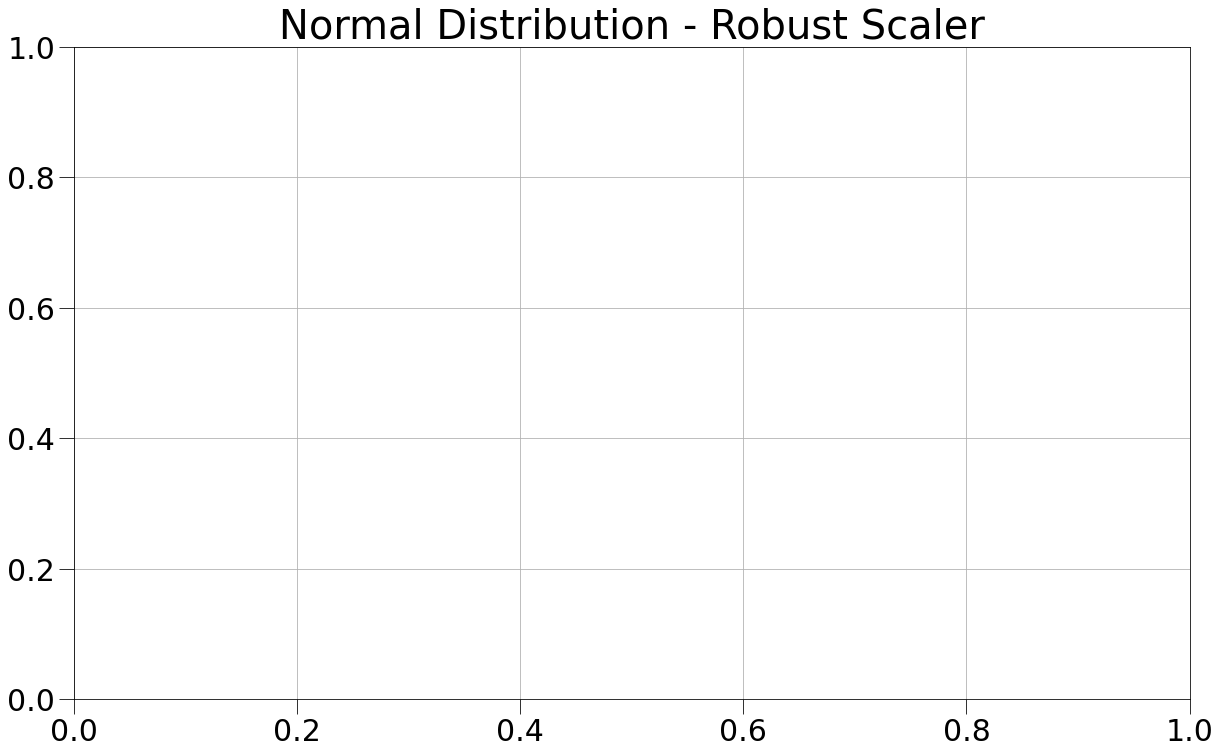

In [14]:
plt.figure(figsize=(20,12))
plt.grid()
plt.title("Normal Distribution - Robust Scaler", fontsize=40)
plt.tick_params(axis='x', size=15)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', size=15)
plt.tick_params(axis='y', labelsize=30)
plt.plot(np.sort(Data_4Y_scaled["Humidity(%)"]), norm.pdf(np.sort(Data_4Y_scaled["Humidity(%)"]), np.mean(Data_4Y_scaled["Humidity(%)"]), np.std(Data_4Y_scaled["Humidity(%)"])), 
         label="Humidity", linewidth=3)
plt.plot(np.sort(Data_4Y_scaled["Watt"]), norm.pdf(np.sort(Data_4Y_scaled["Watt"]), np.mean(Data_4Y_scaled["Watt"]), np.std(Data_4Y_scaled["Watt"])), 
         label="Watt", linewidth=3)
plt.plot(np.sort(Data_4Y_scaled["Temp('C)"]), norm.pdf(np.sort(Data_4Y_scaled["Temp('C)"]), np.mean(Data_4Y_scaled["Temp('C)"]), np.std(Data_4Y_scaled["Temp('C)"])), 
         label="Temp", linewidth=3)
plt.legend(fontsize=25)
plt.margins(x=0.02)
plt.xlim([-5.2, 7.6])
plt.savefig('./Result/Data_Normal_Distribution_Robust.png')
plt.show()   

#### 전력 데이터 변화폭 재확인

In [ ]:
plt.figure(figsize=(30,10))
plt.grid()
plt.margins(x=0.02)
plt.plot(Data_4Y_scaled["Watt"])
plt.show()

### 7. 데이터셋 편집

In [29]:
TEST_SIZE = 1*60*24*365 #1년치를 테스트셋으로 사용
WINDOW_SIZE = 7 #얼마 동안의 과거 기반의 데이터로 다음값을 예측할 것인지 설정. 
BATCH_SIZE = 32
VAL_DAYS = 525600

In [30]:
# train과 test셋 분할
learning = Data_4Y_scaled[:-TEST_SIZE] # 학습에 쓰이는 전체 데이터
VAL_RATIO=VAL_DAYS/len(learning)
VAL_SIZE = int(len(learning)*VAL_RATIO)
TRAIN = learning[:-VAL_SIZE]
VAL = learning[-VAL_SIZE:]
TEST = Data_4Y_scaled[-TEST_SIZE:]
print(len(TRAIN), len(VAL), len(TEST))

1051200 525600 525600


In [31]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [32]:
train_data = windowed_dataset(TRAIN, WINDOW_SIZE, BATCH_SIZE, False) 
valid_data = windowed_dataset(VAL, WINDOW_SIZE, BATCH_SIZE, False)
test_data = windowed_dataset(TEST, WINDOW_SIZE, BATCH_SIZE, False)

### 8. 딥러닝 모델

In [33]:
LeakyReLU=tf.keras.layers.LeakyReLU(alpha=0.1)

model = Sequential([
    Conv1D(filters=8, kernel_size=4, padding="causal", activation=LeakyReLU, input_shape=[WINDOW_SIZE, TRAIN.shape[1]]),
    MaxPooling1D(pool_size=2, strides=1, padding="same"),
    Conv1D(filters=8, kernel_size=4, padding="causal", activation=LeakyReLU),
    MaxPooling1D(pool_size=2, strides=1, padding="same"),
    Bidirectional(LSTM(4, activation=LeakyReLU, return_sequences=True), merge_mode="sum"),
    TimeDistributed(Dense(8)),
    Bidirectional(LSTM(4, activation=LeakyReLU, return_sequences=True), merge_mode="sum"),
    TimeDistributed(Dense(4)),
    Bidirectional(LSTM(2, activation=LeakyReLU, return_sequences=False), merge_mode="sum"),
    Dense(1)
                    ])

Nadam = tf.keras.optimizers.Nadam(learning_rate=0.0004)
model.compile(loss='mean_absolute_error', optimizer=Nadam)
print('\n'*4)
model.summary()






Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 7, 8)              72        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 7, 8)             0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 8)              264       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 7, 8)             0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 7, 4)             416       
 nal)                                                            
                                                 

#### Plot model 저장

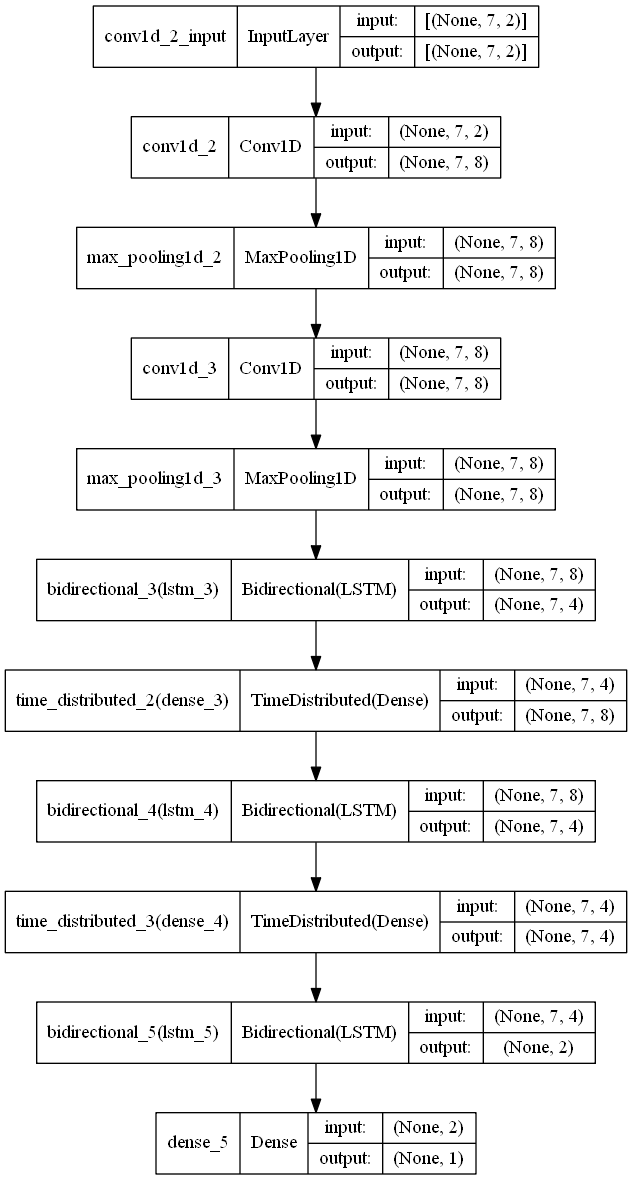

In [34]:
plot_model(model, to_file='./Result/CNN+LSTM/model.png')
plot_model(model, to_file='./Result/CNN+LSTM/model_shapes.png', show_shapes=True)

#### 학습

In [35]:
start=datetime.datetime.now()
early_stop = EarlyStopping(monitor='val_loss', patience=10)

with tf.device('/GPU:0'):
    model_path = 'model'
    filename = os.path.join(model_path, "tmp_checkpoint_main.h5")
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    history = model.fit(train_data, epochs=50, batch_size=BATCH_SIZE, validation_data=(valid_data), callbacks=[checkpoint, early_stop])

model.load_weights(filename)
pred = model.predict(test_data)
pred.shape
end=datetime.datetime.now()
print("\n소요시간 >>", end-start)

Epoch 1/50
  32850/Unknown - 4540s 138ms/step - loss: 0.0099
Epoch 00001: val_loss improved from inf to 0.00815, saving model to model\tmp_checkpoint_main.h5
32850/32850 [==============================] - 4857s 148ms/step - loss: 0.0099 - val_loss: 0.0082
Epoch 2/50
32850/32850 [==============================] - ETA: 0s - loss: 0.0076
Epoch 00002: val_loss improved from 0.00815 to 0.00795, saving model to model\tmp_checkpoint_main.h5
32850/32850 [==============================] - 5070s 154ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 3/50
32850/32850 [==============================] - ETA: 0s - loss: 0.0074
Epoch 00003: val_loss improved from 0.00795 to 0.00791, saving model to model\tmp_checkpoint_main.h5
32850/32850 [==============================] - 4898s 149ms/step - loss: 0.0074 - val_loss: 0.0079
Epoch 4/50
32850/32850 [==============================] - ETA: 0s - loss: 0.0074
Epoch 00004: val_loss improved from 0.00791 to 0.00774, saving model to model\tmp_checkpoint_main.h5
32

In [64]:
model.load_weights(filename)
pred = model.predict(test_data)
pred.shape

(525593, 1)

### 9. 결과 표시

In [37]:
try:
    os.mkdir('./Result/CNN+LSTM')
    os.mkdir('./Result/CNN+LSTM/Graph')
    os.mkdir('./Result/CNN+LSTM/Data')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


<function matplotlib.pyplot.show(close=None, block=None)>

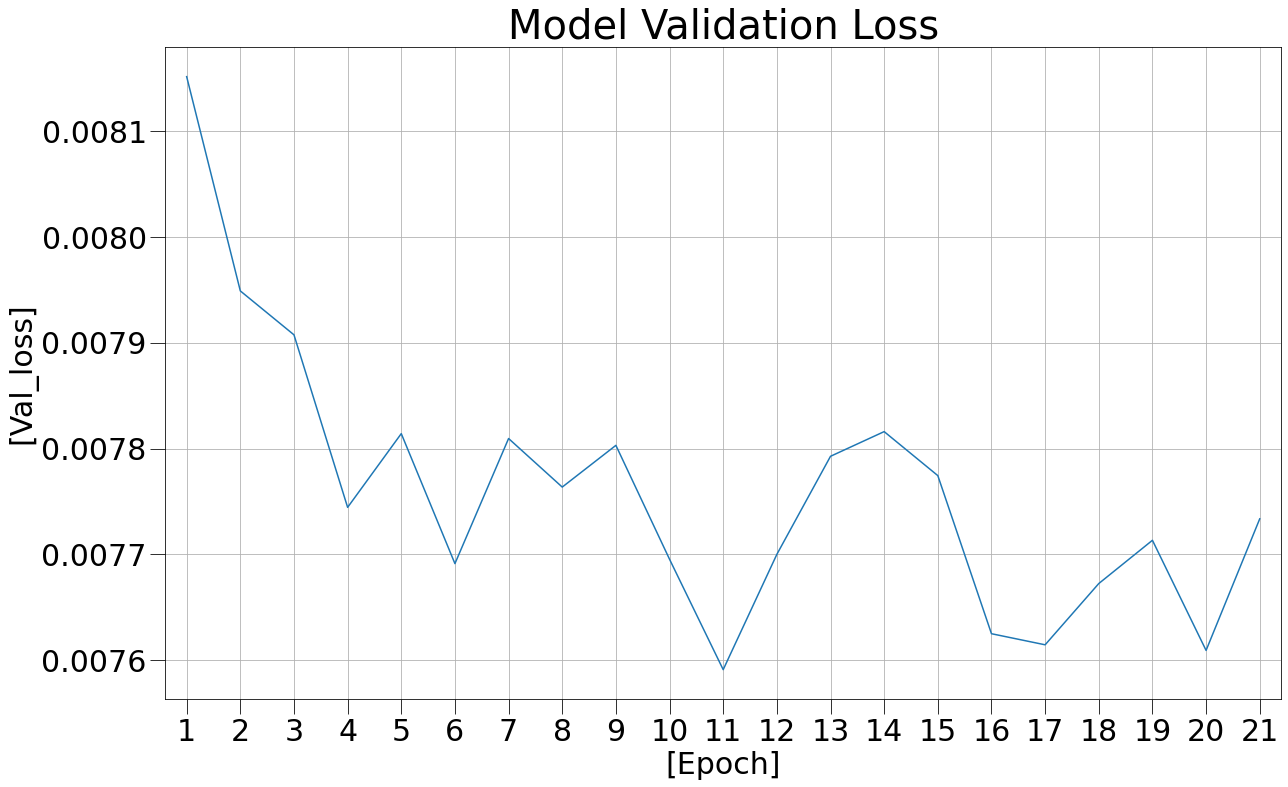

In [168]:
plt.figure(figsize=(20, 12))
plt.title('Model Validation Loss', fontsize=40)
plt.tick_params(axis='x', size=15)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', size=15)
plt.tick_params(axis='y', labelsize=30)
plt.xticks(range(0,len(history.history['val_loss'])), labels=range(1,len(history.history['val_loss'])+1))
plt.xlabel('[Epoch]', size=30)
plt.ylabel('[Val_loss]', size=30)
plt.grid(True)
plt.plot(history.history['val_loss'])
plt.margins(x=0.02)
plt.savefig("./Result/CNN+LSTM/Graph/Model_Valdation_Loss_"+Scaler_Name+".png")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

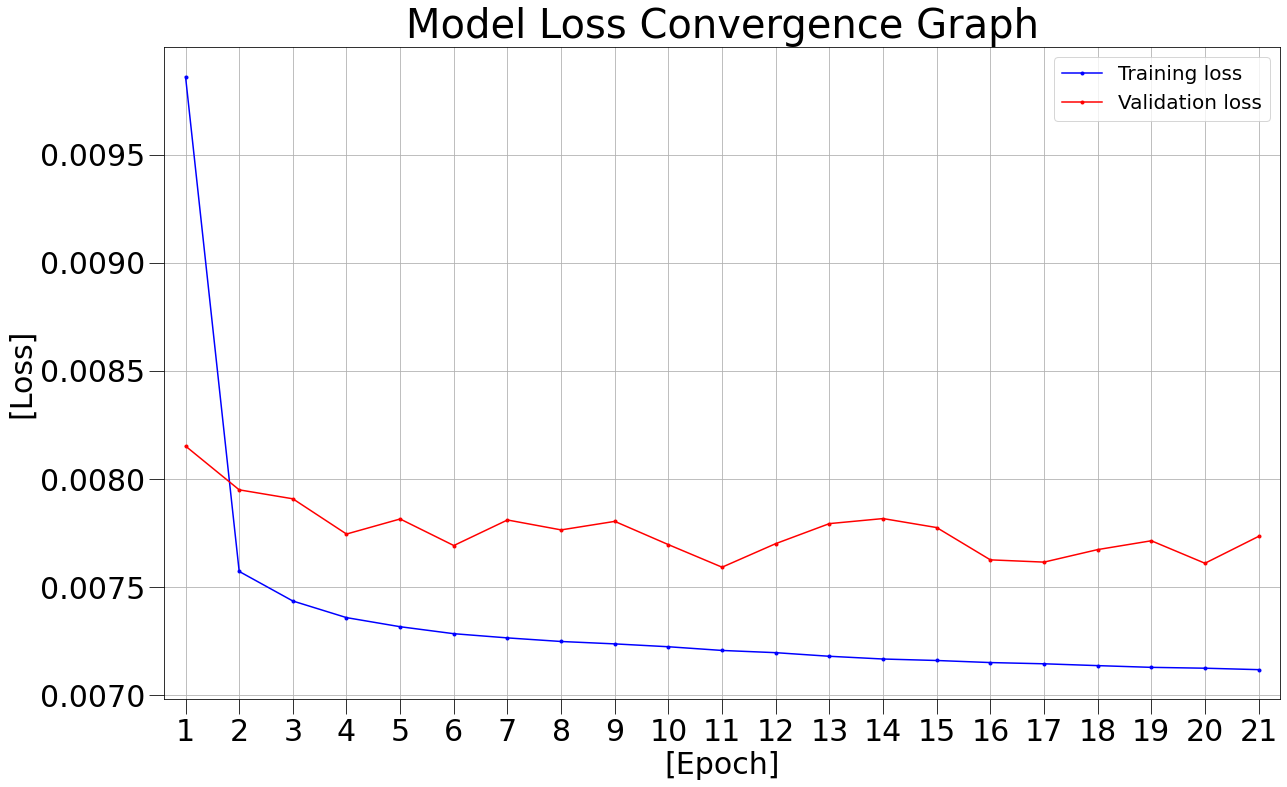

In [174]:
plt.figure(figsize=(20, 12))
plt.title('Model Loss Convergence Graph', fontsize=40)
plt.tick_params(axis='x', size=15)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', size=15)
plt.tick_params(axis='y', labelsize=30)
plt.xticks(range(0,len(history.history['val_loss'])), labels=range(1,len(history.history['val_loss'])+1))
y_tloss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = np.arange(len(y_tloss))
plt.xlabel('[Epoch]', size=30)
plt.ylabel('[Loss]', size=30)
plt.grid(True)
plt.plot(x_len, y_tloss, "o-", c="blue", markersize=3)
plt.plot(x_len, y_vloss, "o-", c="red", markersize=3)
plt.margins(x=0.02)
plt.legend(['Training loss', 'Validation loss'], fontsize=20)
plt.savefig("./Result/CNN+LSTM/Graph/Model_Loss_Convergence_Graph_"+Scaler_Name+".png")
plt.show

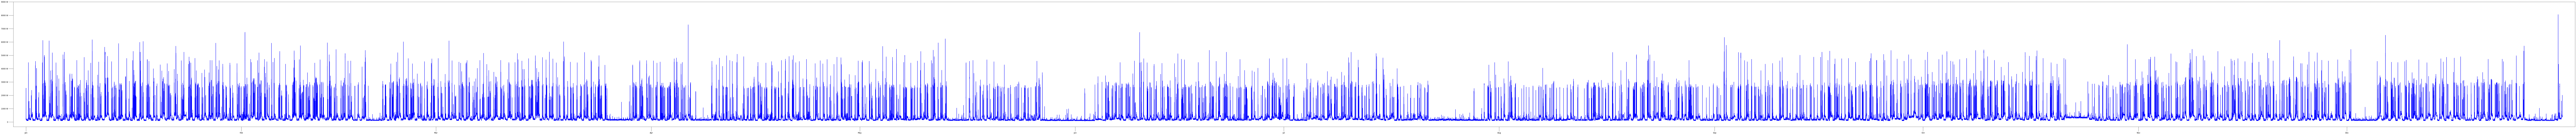

In [86]:
plt.figure(figsize=(300, 15))

plt.tick_params(axis='x', size=20)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', size=20)
plt.tick_params(axis='y', labelsize=30)

plt.plot(pred, label = 'Prediction',color='blue')

plt.xticks([0, 31*24*60, 59*24*60, 90*24*60, 120*24*60, 151*24*60, 181*24*60, 212*24*60, 243*24*60, 273*24*60, 304*24*60, 334*24*60], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], 
               labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W', '9000 W'])

plt.margins(x=0.005)
plt.savefig('./Result/CNN+LSTM/Graph/Prediction.png')
plt.show()

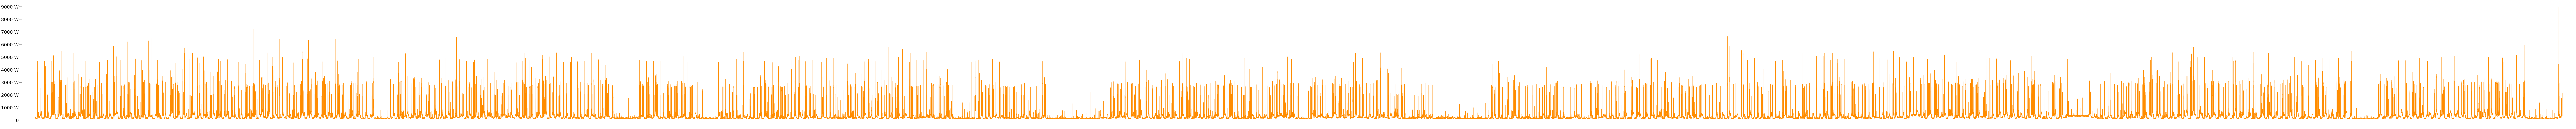

In [91]:
plt.figure(figsize=(300, 15))

plt.tick_params(axis='x', size=20)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', size=20)
plt.tick_params(axis='y', labelsize=30)

plt.plot(TEST['Watt'][:-WINDOW_SIZE], label = 'Actual', color='darkorange')

plt.xticks([0, 31*24*60, 59*24*60, 90*24*60, 120*24*60, 151*24*60, 181*24*60, 212*24*60, 243*24*60, 273*24*60, 304*24*60, 334*24*60], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], 
               labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W', '9000 W'])

plt.margins(x=0.005)
plt.savefig('./Result/CNN+LSTM/Graph/Actual.png')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

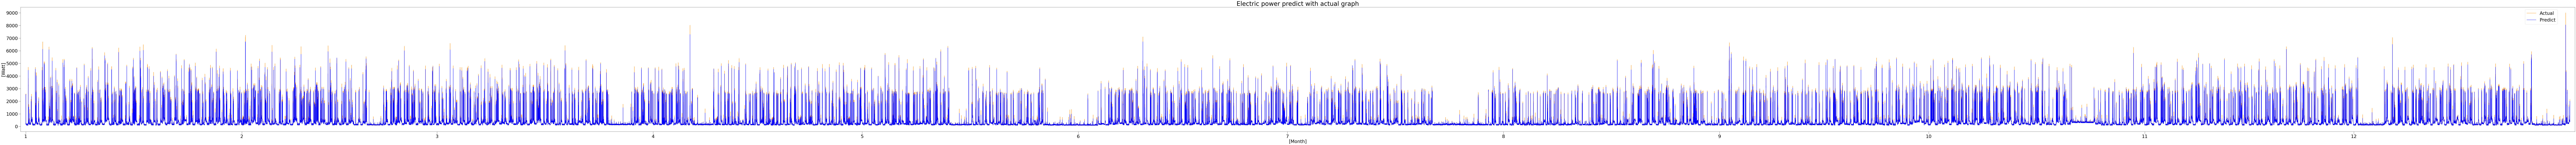

In [195]:
plt.figure(figsize=(300, 15))
plt.title('Electric power predict with actual graph', fontsize=40)
plt.tick_params(axis='x', size=15)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', size=15)
plt.tick_params(axis='y', labelsize=30)

x_len = np.arange(len(pred))

plt.xticks([0, 1440*31, 1440*59, 1440*90, 1440*120, 1440*151, 1440*181, 1440*212, 1440*243, 1440*273, 1440*304, 1440*334], labels=range(1, 13))
plt.yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], labels=range(0, 10000, 1000))

plt.xlabel('[Month]', size=30)
plt.ylabel('[Watt]', size=30)

plt.plot(x_len, TEST['Watt'][:-WINDOW_SIZE], "-", c="darkorange", markersize=3)
plt.plot(x_len, pred, "-", c="blue", markersize=3)

plt.margins(x=0.002)
plt.legend(['Actual', 'Predict'], fontsize=30, loc=1, bbox_to_anchor=(0.994, 1, 0, 0))
plt.savefig("./Result/CNN+LSTM/Graph/Predict_With_Actual_Graph_"+Scaler_Name+".png")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

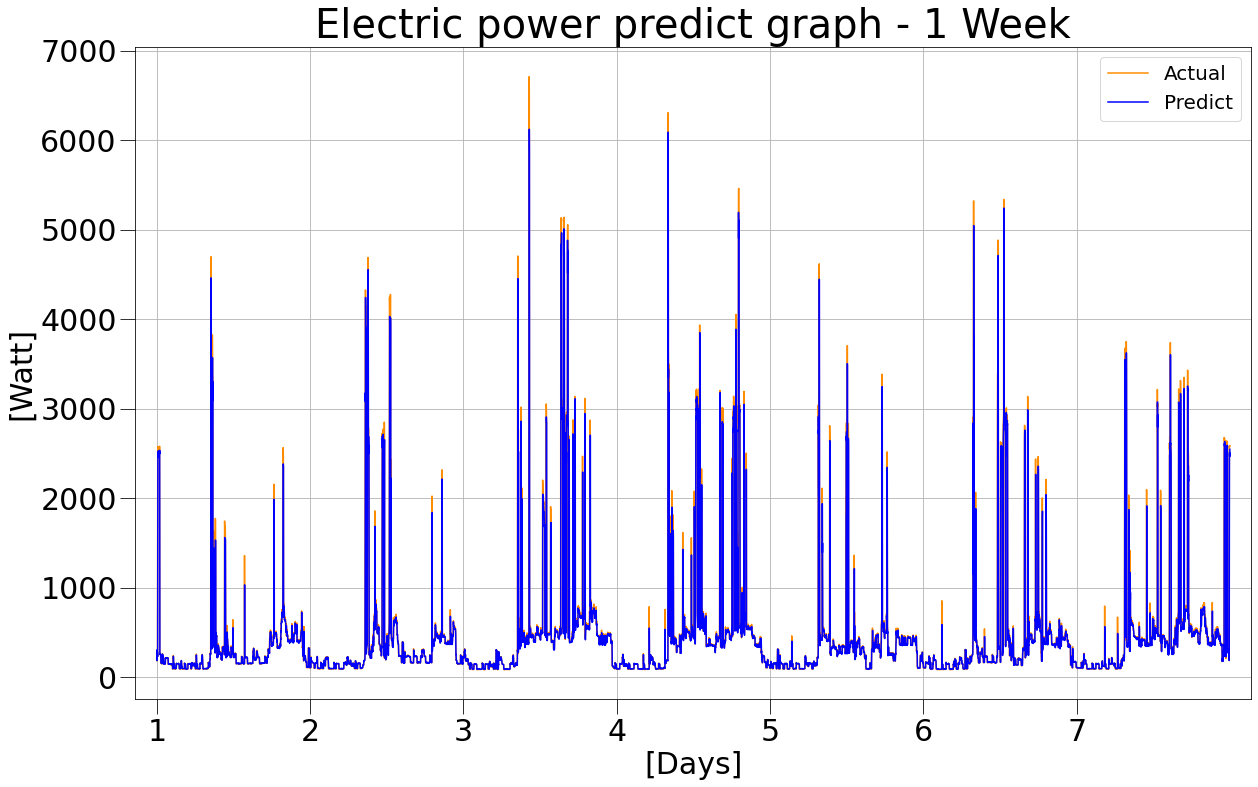

In [176]:
plt.figure(figsize=(20, 12))
plt.title('Electric power predict graph - 1 Week', fontsize=40)
plt.tick_params(axis='x', size=15)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', size=15)
plt.tick_params(axis='y', labelsize=30)

x_len = np.arange(len(pred[0:1440*7]))

plt.xticks(range(0,len(pred[0:1440*7]), 1440), labels=range(1, 8))
plt.yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], labels=range(0, 10000, 1000))

plt.xlabel('[Days]', size=30)
plt.ylabel('[Watt]', size=30)

plt.plot(x_len, TEST['Watt'][WINDOW_SIZE:1440*7+WINDOW_SIZE], "-", c="darkorange", markersize=3)
plt.plot(x_len, pred[0:1440*7], "-", c="blue", markersize=3)

plt.grid(True)
plt.margins(x=0.02)
plt.legend(['Actual', 'Predict'], fontsize=20)
plt.savefig("./Result/CNN+LSTM/Graph/Predict_With_Actual_Graph_Week_"+Scaler_Name+".png")
plt.show

### 수치 결과

In [162]:
def SMAPE(y_test, y_pred):
    return np.mean((np.abs(y_test-y_pred))/(np.abs(y_test)+np.abs(y_pred)))*100/2

true = TEST['Watt2'][:-WINDOW_SIZE].to_numpy()
true = true.reshape(-1,1)

MAE = MAE(true, pred)
RMSE = np.sqrt(MSE(true, pred))
SMAPE0 = SMAPE(true, pred)

TypeError: 'numpy.float64' object is not callable

In [71]:
print('r2 >> %.4f' %r2(true, pred)) # 1에 가까워야 좋음
print('MAE >> %.4f' %MAE) # 0에 가까워야 좋음
print('RMSE >> %.4f' %RMSE) # 0에 가까워야 좋음
print('SMAPE >> %.4f' %SMAPE0) # 0에 가까워야 좋음

r2 >> 0.0065
MAE >> 0.0185
RMSE >> 0.0618
SMAPE >> 5.4770


### 이밑은 다시 월단위 그래프 표시 코드

In [ ]:
# 월 단위 그래프 분할 표시 및 저장
for m in range(1,13):
    month = {0:0, 1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    
    start = {1:0, 2:744, 3:1416, 4:2160, 5:2880, 6:3624, 7:4344, 8:5088, 9:5832, 10:6552, 11:7296, 12:8016}
    end = {1:744, 2:1416, 3:2160, 4:2880, 5:3624, 6:4344, 7:5088, 8:5832, 9:6552, 10:7296, 11:8016, 12:8760}
        
    ax2.set_title('Prediction & Actual Graph - month'+str(m), size='15')
    
    watt_list=TEST['Watt'][:-WINDOW_SIZE].tolist()
    
    fig = plt.figure(figsize=(30,12)) 
    ax1 = fig.add_subplot() # subplot 그래프 생성
    ax1.tick_params(axis='y', size=20, labelsize=20) # y축 눈금 표기 설정
    ax1.set_yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], 
           labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W','9000 W'])
    
    # Actual
    color1 = 'darkorange'
    ax1.plot(watt_list[start[m]:end[m]], color=color1, marker='.')
    ax1.tick_params(axis='x', size=20, labelsize=20)
    ax1.margins(x=0.005)
    ax1.legend(['Actual'], loc=1, bbox_to_anchor=(0.95, 1, 0, 0))
    
    # Predict
    color2 = 'blue'
    ax2 = ax1.twiny()
    ax2.plot(pred[start[m]:end[m]], color=color2, marker='.')
    ax2.tick_params(axis='x', size=20, labelsize=20)
    ax2.xaxis.set_visible(False)
    ax2.margins(x=0.005)
    ax2.legend(['Predict'], loc=1, bbox_to_anchor=(1, 1, 0, 0))
    
    # 월별 xticks 설정 함수
    def xticks_list (days):
        xticks_list=[]
        for x in range(0,days+1):
            xticks_list.append(x*24)
        return xticks_list
    
    # month labels 설정 함수
    def month_labels (days):
        month_labels=[]
        for ml in range(1,days+1):
            month_labels.append(ml)
        month_labels.append('end') 
        return month_labels
    
    if (m==2):
        ax1.set_xticks(xticks_list(28), labels=month_labels(28))

    if (m==4 or m==6  or m==9 or m==11):
        ax1.set_xticks(xticks_list(30), labels=month_labels(30))
        
    if (m==1 or m==3 or m==5 or m==7 or m==8 or m==10 or m==12):
        ax1.set_xticks(xticks_list(31), labels=month_labels(31))
        
    ax1.set_yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], 
           labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W','9000 W'])
    
    plt.suptitle('Prediction_with_Actual_'+str(m),fontsize=20)
    plt.grid(True)
    plt.savefig('./Result/CNN+LSTM/Graph/Prediction_with_Actual_'+str(m)+'.png')
    plt.show()

#### 그래프 비교 결과

In [ ]:
import cv2
from skimage.metrics import structural_similarity as ssim

In [ ]:
# 유사도 측정을 위한 이미지 가공
image1 = cv2.imread('./Result/CNN+LSTM/Graph/Prediction.png')
image2 = cv2.imread('./Result/CNN+LSTM/Graph/Actual.png')

tempDiff1 = cv2.subtract(image1, image2)

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

In [ ]:
# 차이 추출을 위한 뺄셈 과정
pred_list=pred.tolist()
actual_list=TEST['Watt'][:-WINDOW_SIZE].tolist()

In [ ]:
(score, diff) = ssim(gray1, gray2, full=True)
sim_score = round(score,5)*100

print('그래프 유사도 ==>> %.3f %%' %sim_score)